# Load Data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import string
import re
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Feature Extraction
Add features:
- Total word counts (cleaned)
- Urls per comment
- Question marks per comment
- Sklearn vectorizer


**Start from the cleanpost data**

In [ ]:
# new_path = '/content/drive/MyDrive/CS289A Project/data/cleaned_mbti_train.csv'
new_path = '/content/drive/MyDrive/CS289A Project/data/old data (w o removing mbti words)/cleaned_mbti_train.csv'
df_train = pd.read_csv(new_path).drop(columns=['Unnamed: 0'])

In [ ]:
df_train['http_per_comment'] = df_train['posts'].apply(lambda x: x.count('http')/50)
df_train['qm_per_comment'] = df_train['posts'].apply(lambda x: x.count('?')/50)

In [ ]:
# new_path_test = '/content/drive/MyDrive/CS289A Project/data/cleaned_mbti_test.csv'
new_path_test = '/content/drive/MyDrive/CS289A Project/data/old data (w o removing mbti words)/cleaned_mbti_test.csv'
df_test = pd.read_csv(new_path_test).drop(columns=['Unnamed: 0'])

In [ ]:
df_test['http_per_comment'] = df_test['posts'].apply(lambda x: x.count('http')/50)
df_test['qm_per_comment'] = df_test['posts'].apply(lambda x: x.count('?')/50)

**Vectorize Clean Posts**

In [ ]:
# Tf-idf vectorizer
nfeat = 2000
vectorizer = TfidfVectorizer(max_features=nfeat) # max_features may change
vectorizer.fit(df_train.clean_posts)
feature_names=vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Tf-idf vectorizer
train_post=vectorizer.transform(df_train.clean_posts).toarray()
test_post=vectorizer.transform(df_test.clean_posts).toarray()

Concatonate all features to get a **train_design** matrix\
Whitening all features

In [ ]:
# concatenate other features
train_remain = np.stack((df_train.clean_word_counts, df_train.http_per_comment, df_train.qm_per_comment), axis=1)
train_design = np.concatenate((train_post,train_remain), axis=1)

# concatenate other features
test_remain = np.stack((df_test.clean_word_counts, df_test.http_per_comment, df_test.qm_per_comment), axis=1)
test_design = np.concatenate((test_post,test_remain), axis=1)

In [ ]:
X_train_list = []; X_test_list = []
# 0. tfid + 3 add feats w/o whitening
X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [ ]:
# 1. tfid + 3 add feats with whitening the 3 add feats.
train_mean = np.average(train_design,axis=0)
train_var = np.average(train_design,axis=0)
train_design[:,-3:]=(train_design[:,-3:] - train_mean[-3:]) / np.sqrt(train_var[-3:])
test_design[:,-3:]=(test_design[:,-3:] - train_mean[-3:]) / np.sqrt(train_var[-3:])

X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [ ]:
# 2. tfid + 3 add feats with whitening all feats
train_design[:,:-3]=(train_design[:,:-3] - train_mean[:-3]) / np.sqrt(train_var[:-3])
test_design[:,:-3]=(test_design[:,:-3] - train_mean[:-3]) / np.sqrt(train_var[:-3])

X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [ ]:
# 3. tfid w/o whitening
X_train_list.append(np.copy(X_train_list[0][:,:-3])); X_test_list.append(np.copy(X_test_list[0][:,:-3]));
# 4. tfid with whitening
X_train_list.append(np.copy(X_train_list[2][:,:-3])); X_test_list.append(np.copy(X_test_list[2][:,:-3]));

**Setting up y-labels**: 16 classes (ranging from 0-15 representing 16 Myers-briggs personality types)\
INFJ - 0\
INFP - 1\
INTJ - 2\
INTP - 3\
ISFJ - 4\
ISFP - 5\
ISTJ - 6\
ISTP - 7\
ENFJ - 8\
ENFP - 9\
ENTJ - 10\
ENTP - 11\
ESFJ - 12\
ESFP - 13\
ESTJ - 14\
ESTP - 15


In [ ]:
# train/test_pers_bin : splitted MBTI types
# I/E  N/S  F/T  J/P
pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
def trans_per(mtype):
  return [pers[l] for l in mtype]

def bin_2_num(bin):
  res = 0; n = len(bin)
  for ielem, bin_val in enumerate(bin):
    res += bin_val*pow(2,n-1-ielem)
  return res

# can train each personality
train_pers_bin = np.array([trans_per(p) for p in df_train.type])
# train_target
train_target = np.array([bin_2_num(bin) for bin in train_pers_bin])


In [ ]:
class16_mbti_map = {
    0:"INFJ",
    1:"INFP",
    2:"INTJ",
    3:"INTP",
    4:"ISFJ",
    5:"ISFP",
    6:"ISTJ",
    7:"ISTP",
    8:"ENFJ",
    9:"ENFP",
    10:"ENTJ",
    11:"ENTP",
    12:"ESFJ",
    13:"ESFP",
    14:"ESTJ",
    15:"ESTP",
}

In [ ]:
# can train each personality
test_pers_bin = np.array([trans_per(p) for p in df_test.type])
# train_target
test_target = np.array([bin_2_num(bin) for bin in test_pers_bin])

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [ ]:
cv = 5 # May change

In [ ]:
y_train = np.copy(train_target)
y_test = np.copy(test_target)

**Brief dim reduction**

In [ ]:
from sklearn.decomposition import PCA
pca_dim = 500
for ielem in range(5):
  pca = PCA(n_components=pca_dim,random_state=248)
  tmp_train = pca.fit_transform(X_train_list[ielem])
  tmp_test = pca.transform(X_test_list[ielem])
  X_train_list.append(tmp_train)
  X_test_list.append(tmp_test)

**Aug data**

In [ ]:
if False:
  # Add Aug Data
  root_path = '/content/drive/MyDrive/CS289A Project/'
  data_path = root_path + 'data/'
  train_aug_data_path = data_path + 'df_train_aug.csv'
  train_aug = pd.read_csv(train_aug_data_path)

  test_aug_data_path = data_path + 'df_test_aug.csv'
  test_aug = pd.read_csv(test_aug_data_path)
  X_train_aug = train_aug.to_numpy()[:,1:]
  X_test_aug = test_aug.to_numpy()[:,1:]
  train_mean_aug = np.average(X_train_aug,axis=0)
  train_var_aug = np.var(X_train_aug, axis=0)
  X_train_aug = (X_train_aug-train_mean_aug)/np.sqrt(train_var_aug)
  X_test_aug = (X_test_aug-train_mean_aug)/np.sqrt(train_var_aug)

  X_train_list.append(X_train_aug)
  X_test_list.append(X_test_aug)

**Sanity check**
- The list of design matrices consist of
0. Tfid vector with add. features(n_features = nfeat+3) w/o whitening
1. Tfid vector with add. features(n_features = nfeat+3) with whitening 3 add feats. 
2. Tfid vector with add. features(n_features = nfeat+3) with complete whitening
3. Tfid vector w/o add. features(n_features = nfeat) w/o whitening
4. Tfid vector w/o add. features(n_features = nfeat) with whitening
5. PCA of 0.
6. PCA of 1.
7. PCA of 2.
8. PCA of 3.
9. PCA of 4.

In [ ]:
print('nfeat = ', nfeat)
print('pca_dim = ', pca_dim)
for design in X_train_list:
  print(design.shape)

nfeat =  2000
pca_dim =  500
(6940, 2003)
(6940, 2003)
(6940, 2003)
(6940, 2000)
(6940, 2000)
(6940, 500)
(6940, 500)
(6940, 500)
(6940, 500)
(6940, 500)


# (DONE) DESIGN MATRICES

# Classification
- Logistic Regression
- SVM
- QDA
- Boosting (this case ada)
- Decision Tree Classifier
- Random Forest
1. compare CV accuracies of all classifiers (GridSearchCV or RandomizedSearchCV)
2. hyperparameter tuning
3. feature selection
4. visualization -- T-sne https://distill.pub/2016/misread-tsne/ compress 2000 features into 2D or 3D,
5. include error bars if appropriate (classifiers with randomness included)

MLP


**1. Logistic Regression**

Matrix 3, 8 have best results

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.stats import loguniform

In [ ]:
if True:
  import warnings
  warnings.filterwarnings("ignore")
  from sklearn.exceptions import ConvergenceWarning
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
logreg_clf_list = []
for X_train in X_train_list:
  logreg_clf = LogisticRegression()
  logreg_clf.fit(X_train,y_train)
  logreg_clf_list.append(logreg_clf)

In [ ]:
for ielem, logreg_clf in enumerate(logreg_clf_list):
  print('design matrix', ielem)
  print('training score:', logreg_clf.score(X_train_list[ielem],y_train))
  print('test score:', logreg_clf.score(X_test_list[ielem],y_test))

design matrix 0
training score: 0.6210374639769453
test score: 0.5723342939481268
design matrix 1
training score: 0.6995677233429395
test score: 0.6288184438040346
design matrix 2
training score: 1.0
test score: 0.5342939481268012
design matrix 3
training score: 0.7726224783861672
test score: 0.6380403458213256
design matrix 4
training score: 0.9998559077809799
test score: 0.5296829971181556
design matrix 5
training score: 0.230835734870317
test score: 0.2270893371757925
design matrix 6
training score: 0.6482708933717579
test score: 0.6011527377521614
design matrix 7
training score: 0.8377521613832853
test score: 0.577521613832853
design matrix 8
training score: 0.7201729106628242
test score: 0.6432276657060518
design matrix 9
training score: 0.8426512968299712
test score: 0.575792507204611


In [ ]:
X_train_3 = X_train_list[3]
X_test_3 = X_test_list[3]
y_train

array([11,  0,  2, ...,  0,  2,  0])

In [ ]:
# dim_list = [100,200,300,400,500,600,700,800,900,1000]
#dim_list = [1100,1200,1300,1400,1500]
dim_list = np.arange(100,1301,100)
for pca_dim in dim_list:
  print('pca_dim:', pca_dim)
  # pca_dim = 100
  pca = PCA(n_components=pca_dim,random_state=248)
  X_train_tmp = pca.fit_transform(X_train_3)
  X_test_tmp = pca.transform(X_test_3)

  logreg_clf = LogisticRegression()
  logreg_clf.fit(X_train_tmp,y_train)
  scores = cross_val_score(logreg_clf, X_train_tmp, y_train, cv=cv)

  print('training score:', logreg_clf.score(X_train_tmp,y_train))
  print('cv result:', scores.mean(), scores.var())
  print('test score:', logreg_clf.score(X_test_tmp,y_test))

pca_dim: 100
training score: 0.6834293948126802
cv result: 0.6580691642651296 6.698004302003999e-05
test score: 0.6380403458213256
pca_dim: 200
training score: 0.698270893371758
cv result: 0.6572046109510087 6.382413274755213e-05
test score: 0.6472622478386167
pca_dim: 300
training score: 0.7073487031700288
cv result: 0.6577809798270894 4.733865408731898e-05
test score: 0.6472622478386167
pca_dim: 400
training score: 0.7164265129682997
cv result: 0.6523054755043228 5.036998895431416e-05
test score: 0.6409221902017291
pca_dim: 500
training score: 0.7201729106628242
cv result: 0.6498559077809798 9.758406763614018e-05
test score: 0.6432276657060518
pca_dim: 600
training score: 0.7268011527377521
cv result: 0.6517291066282421 8.691210789891087e-05
test score: 0.6449567723342939
pca_dim: 700
training score: 0.7321325648414986
cv result: 0.6488472622478386 8.255196870665827e-05
test score: 0.6380403458213256
pca_dim: 800
training score: 0.7370317002881844
cv result: 0.6471181556195965 4.6798

In [ ]:

pca = PCA(n_components=300,random_state=248)
X_train_tmp = pca.fit_transform(X_train_3)
X_test_tmp = pca.transform(X_test_3)


logistic_clf = LogisticRegression(max_iter=300, tol=1e-3, random_state=1)
# logistic_clf.fit(train_design, train_target)

# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = loguniform(1e-3, 10)

logreg_search = RandomizedSearchCV(logistic_clf, space, scoring='accuracy',  cv=cv, random_state=289)

# execute search
result = logreg_search.fit(X_train_tmp, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

KeyboardInterrupt: ignored

In [ ]:
## Dataset
pca = PCA(n_components=300,random_state=248)
X_train_tmp = pca.fit_transform(X_train_3)
X_test_tmp = pca.transform(X_test_3)


# Best Model
best_logreg = LogisticRegression(
    max_iter=300, tol=1e-3, random_state=289, 
    C= 0.8, penalty= 'l1', solver= 'liblinear')


best_logreg.fit(X_train_tmp, y_train)
y_pred = best_logreg.predict(X_test_tmp)
y_pred_train = best_logreg.predict(X_train_tmp)

# Calculate Scores
logreg_train_scores = CalculateScoresMultiClass(y_train, y_pred_train, 'LogReg', is_train=True)
logreg_test_scores = CalculateScoresMultiClass(y_test,y_pred, 'LogReg', is_train=False)


cm_logistic = confusion_matrix(y_test, y_pred)
print('train classification report \n ',classification_report(y_train,best_logreg.predict(X_train_tmp),target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.70      0.74      0.72      1176
        INFP       0.68      0.85      0.76      1466
        INTJ       0.68      0.73      0.71       873
        INTP       0.69      0.81      0.74      1043
        ISFJ       0.76      0.50      0.60       133
        ISFP       0.76      0.45      0.56       217
        ISTJ       0.69      0.41      0.51       164
        ISTP       0.74      0.64      0.69       270
        ENFJ       0.71      0.27      0.39       152
        ENFP       0.72      0.65      0.68       540
        ENTJ       0.77      0.42      0.55       185
        ENTP       0.70      0.64      0.67       548
        ESFJ       0.67      0.06      0.11        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.65      0.21      0.32        71

    accuracy                           0.70      

In [ ]:
import matplotlib.pyplot as plt
# Create Dataframe
models_plot = pd.DataFrame.from_dict([logreg_train_scores,logreg_test_scores])
models_plot

,Model,is_Train,Test_Accuracy,Test_Precision,Test_Recall,F1
0,LogReg,True,0.697695,0.620709,0.461406,0.501045
1,LogReg,False,0.653026,0.602786,0.410918,0.452271


**2. SVM**

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_clf_list = []
for X_train in X_train_list:
  svm_clf = SVC()
  svm_clf.fit(X_train,y_train)
  svm_clf_list.append(svm_clf)

In [ ]:
for ielem, svm_clf in enumerate(svm_clf_list):
  print('design matrix', ielem)
  print('training score:', svm_clf.score(X_train_list[ielem],y_train))
  print('test score:', svm_clf.score(X_test_list[ielem],y_test))

design matrix 0
training score: 0.21123919308357347
test score: 0.21095100864553315
design matrix 1
training score: 0.3095100864553314
test score: 0.2876080691642651
design matrix 2
training score: 0.9389048991354467
test score: 0.553314121037464
design matrix 3
training score: 0.9404899135446686
test score: 0.6293948126801153
design matrix 4
training score: 0.9560518731988472
test score: 0.5677233429394812
design matrix 5
training score: 0.21123919308357347
test score: 0.21095100864553315
design matrix 6
training score: 0.31037463976945245
test score: 0.2922190201729107
design matrix 7
training score: 0.8834293948126801
test score: 0.5711815561959654
design matrix 8
training score: 0.9210374639769452
test score: 0.6443804034582132
design matrix 9
training score: 0.9180115273775216
test score: 0.5919308357348703


In [ ]:
# dim_list = [100,200,300,400,500,600,700,800,900,1000]
#dim_list = [1100,1200,1300,1400,1500]
dim_list = np.arange(100,1301,100)
for pca_dim in dim_list:
  print('pca_dim:', pca_dim)
  # pca_dim = 100
  pca = PCA(n_components=pca_dim,random_state=248)
  X_train_tmp = pca.fit_transform(train_design)
  X_test_tmp = pca.transform(test_design)

  svm_clf = SVC()
  svm_clf.fit(X_train_tmp,y_train)
  scores = cross_val_score(svm_clf, X_train_tmp, y_train, cv=cv)

  print('training score:', svm_clf.score(X_train_tmp,y_train))
  print('cv result:', scores.mean(), scores.var())
  print('test score:', svm_clf.score(X_test_tmp,y_test))

pca_dim: 100
training score: 0.7293948126801153
cv result: 0.581700288184438 9.52171349317741e-05
test score: 0.5567723342939481
pca_dim: 200
training score: 0.8011527377521613
cv result: 0.5850144092219021 5.626655814764685e-05
test score: 0.5763688760806917
pca_dim: 300
training score: 0.838328530259366
cv result: 0.5806916426512969 8.38807730319158e-05
test score: 0.5677233429394812
pca_dim: 400
training score: 0.8659942363112392
cv result: 0.5786743515850145 6.13326246376932e-05
test score: 0.5746397694524495
pca_dim: 500
training score: 0.8834293948126801
cv result: 0.5812680115273775 0.000170128478768199
test score: 0.5711815561959654
pca_dim: 600
training score: 0.8933717579250721
cv result: 0.5742074927953891 0.00010941873115796958
test score: 0.5706051873198847
pca_dim: 700
training score: 0.9036023054755044
cv result: 0.572478386167147 0.00013570414171698144
test score: 0.5665706051873198
pca_dim: 800
training score: 0.9113832853025937
cv result: 0.5695965417867435 0.00016580

In [ ]:
pca = PCA(n_components=300,random_state=248)
X_train_tmp = pca.fit_transform(X_train_3)
X_test_tmp = pca.transform(X_test_3)


# RandomizedSearchCV
svm_clf = SVC(max_iter=300, tol=1e-3, random_state=289)

# define search space
space = dict()
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] = loguniform(1e-3, 10)

svm_search = RandomizedSearchCV(svm_clf, space, scoring='accuracy',  cv=cv, random_state=1)

# execute search
result = svm_search.fit(X_train_tmp, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5573487031700288
Best Hyperparameters: {'C': 0.14297724879798387, 'kernel': 'rbf'}


In [ ]:
# Best Model

pca = PCA(n_components=200,random_state=248)
X_train_tmp = pca.fit_transform(X_train_3)
X_test_tmp = pca.transform(X_test_3)

best_svm_clf = SVC(max_iter=-1, tol=1e-3, random_state=1,
                   C= 0.14, kernel= 'rbf')
best_svm_clf.fit(X_train_tmp, y_train)

y_pred = best_svm_clf.predict(X_test_tmp)
y_pred_train = best_svm_clf.predict(X_train_tmp)
cm_svm = confusion_matrix(y_test, y_pred)
# Calculate Scores
svm_train_scores = CalculateScoresMultiClass(y_train, y_pred_train, 'SVM')
svm_test_scores = CalculateScoresMultiClass(y_test,y_pred, 'SVM')
print('train classification report \n ',classification_report(y_train,best_svm_clf.predict(X_train_tmp),target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.71      0.70      0.71      1176
        INFP       0.48      0.92      0.63      1466
        INTJ       0.77      0.68      0.72       873
        INTP       0.64      0.81      0.72      1043
        ISFJ       0.93      0.10      0.18       133
        ISFP       0.86      0.03      0.05       217
        ISTJ       0.57      0.02      0.05       164
        ISTP       0.82      0.35      0.49       270
        ENFJ       0.00      0.00      0.00       152
        ENFP       0.83      0.51      0.63       540
        ENTJ       0.92      0.13      0.23       185
        ENTP       0.80      0.50      0.61       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71

    accuracy                           0.62      

In [ ]:
svm_scores

{'Accuracy': 0.5786743515850145,
 'F1': 0.2936698109280985,
 'Model': 'SVM',
 'Precision': 0.5211151597010656,
 'Recall': 0.27816373127599825}

In [ ]:
logreg_scores

{'Accuracy': 0.6530259365994237,
 'F1': 0.45227130626216994,
 'Model': 'LogReg',
 'Precision': 0.6027856344457041,
 'Recall': 0.4109182363650883}

In [56]:
def PlotScores(model_scores_list, title):
  import matplotlib.pyplot as plt
  # Create Dataframe
  models_plot = pd.DataFrame.from_dict(model_scores_list)
  print(models_plot)
  # Figsize
  figsize = (20, 6)
  ax = models_plot.plot.bar(rot=0,figsize=figsize)
  ax.set_xticklabels(models_plot.Model)
  ax.set_yticks(np.arange(0,1.1,0.1))
  ax = plt.title(title)

    Model  is_Train  Test_Accuracy  Test_Precision  Test_Recall        F1
0  LogReg     False       0.653026        0.602786     0.410918  0.452271


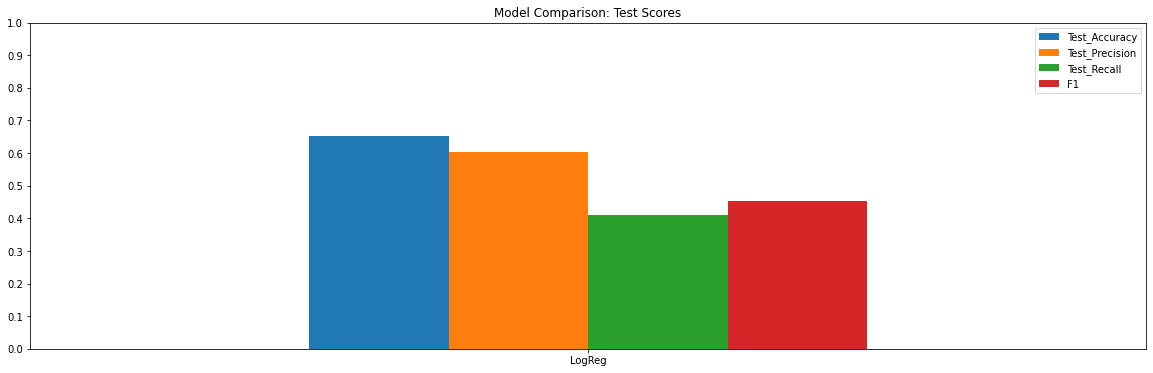

In [58]:
# Plot
PlotScores([logreg_test_scores], title = 'Model Comparison: Test Scores')

    Model  Accuracy  Precision    Recall        F1
0  LogReg  0.697695   0.620709  0.461406  0.501045
1     SVM  0.621182   0.520637  0.297201  0.313437


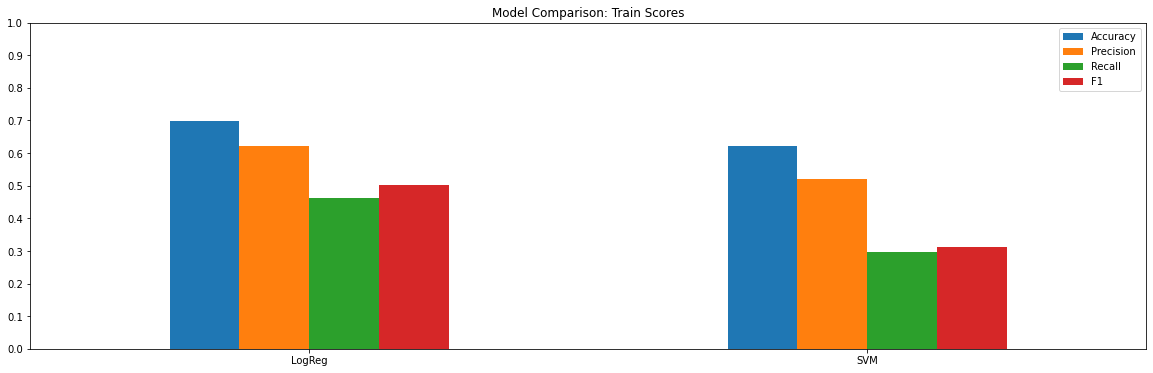

In [ ]:
# Plot
PlotScores([logreg_train_scores, svm_train_scores], title = 'Model Comparison: Train Scores')

**3. QDA**

In [ ]:
if False:
  import warnings
  warnings.filterwarnings('ignore')

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# RandomizedSearchCV
qda_clf = QuadraticDiscriminantAnalysis()

# define search space
qda_space = [{'reg_param': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]}]

qda_search = RandomizedSearchCV(qda_clf, qda_space, scoring='accuracy',  cv=cv, random_state=1)

# execute search
qda_result = qda_search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % qda_result.best_score_)
print('Best Hyperparameters: %s' % qda_result.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


KeyboardInterrupt: ignored

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# Collinear variables in Multiclass -> very bad result
best_qda_clf = QuadraticDiscriminantAnalysis()
best_qda_clf.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [ ]:
# Overfitting
print('training score:', best_qda_clf.score(X_train,y_train))
print('test score:', best_qda_clf.score(X_test,y_test))
# when reg_parama=0.1
# training error: 0.0004322766570605187
# test error: 0.002881844380403458
# aug
# training score: 0.7966858789625361
# test score: 0.2219020172910663

training score: 0.7966858789625361
test score: 0.2219020172910663


In [ ]:
print('train classification report \n ',classification_report(y_train,best_qda_clf.predict(X_train),target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,best_qda_clf.predict(X_test),target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.99      1.00      0.99      1176
        INFP       1.00      0.99      1.00      1466
        INTJ       1.00      1.00      1.00       873
        INTP       1.00      0.99      1.00      1043
        ISFJ       1.00      1.00      1.00       133
        ISFP       1.00      1.00      1.00       217
        ISTJ       1.00      1.00      1.00       164
        ISTP       1.00      1.00      1.00       270
        ENFJ       1.00      1.00      1.00       152
        ENFP       1.00      1.00      1.00       540
        ENTJ       1.00      1.00      1.00       185
        ENTP       1.00      1.00      1.00       548
        ESFJ       1.00      1.00      1.00        33
        ESFP       1.00      1.00      1.00        38
        ESTJ       1.00      1.00      1.00        31
        ESTP       1.00      1.00      1.00        71

    accuracy                           1.00      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random sampler

In [ ]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 
# sampling = dict()
# num = 500
# for ielem in range(16):
#   sampling[ielem] = 500
# rus = RandomUnderSampler(sampling_strategy=sampling,random_state=500)
rus = RandomOverSampler(random_state=10)
if False:
  X_res, y_res = rus.fit_resample(X_train, y_train)
  from collections import Counter
  print('Resampled dataset shape %s' % Counter(y_res))
rs_qda_clf = QuadraticDiscriminantAnalysis()
rs_qda = imb_make_pipeline(rus,rs_qda_clf)
rs_qda.fit(X_train,y_train)

print('training score:', rs_qda.score(X_train,y_train))
print('test score:', rs_qda.score(X_test,y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


training score: 0.840057636887608
test score: 0.23054755043227665


In [ ]:
print('train classification report \n ',classification_report(y_train,rs_qda.predict(X_train),target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,rs_qda.predict(X_test),target_names=list(class16_mbti_map.values())))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train classification report 
                precision    recall  f1-score   support

        INFJ       0.95      1.00      0.97      1176
        INFP       0.59      1.00      0.74      1466
        INTJ       0.99      1.00      0.99       873
        INTP       0.99      1.00      0.99      1043
        ISFJ       1.00      0.05      0.10       133
        ISFP       1.00      0.03      0.05       217
        ISTJ       1.00      0.11      0.20       164
        ISTP       1.00      0.88      0.93       270
        ENFJ       1.00      0.20      0.34       152
        ENFP       1.00      0.85      0.92       540
        ENTJ       1.00      0.06      0.11       185
        ENTP       1.00      0.87      0.93       548
        ESFJ       1.00      1.00      1.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       1.00      0.06      0.12        31
        ESTP       0.00      0.00      0.00        71

    accuracy                           0.84      

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**3-1. LDA**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train,y_train)

print('training score:', lda_clf.score(X_train,y_train))
print('test score:', lda_clf.score(X_test,y_test))

training score: 0.4602305475504323
test score: 0.25302593659942363


In [ ]:
print('train classification report \n ',classification_report(y_train,lda_clf.predict(X_train),target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,lda_clf.predict(X_test),target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.87      0.86      0.86      1176
        INFP       0.87      0.89      0.88      1466
        INTJ       0.87      0.87      0.87       873
        INTP       0.88      0.89      0.89      1043
        ISFJ       0.93      0.92      0.92       133
        ISFP       0.91      0.88      0.90       217
        ISTJ       0.92      0.93      0.92       164
        ISTP       0.92      0.90      0.91       270
        ENFJ       0.87      0.91      0.89       152
        ENFP       0.92      0.88      0.90       540
        ENTJ       0.94      0.94      0.94       185
        ENTP       0.91      0.87      0.89       548
        ESFJ       0.86      0.94      0.90        33
        ESFP       1.00      0.95      0.97        38
        ESTJ       0.94      1.00      0.97        31
        ESTP       0.95      0.99      0.97        71

    accuracy                           0.89      

**3-2 Random sampling test**

In [ ]:
from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 

rus = RandomOverSampler(random_state=10)
if False:
  X_res, y_res = rus.fit_resample(X_train, y_train)
  from collections import Counter
  print('Resampled dataset shape %s' % Counter(y_res))

rs_lda_clf = LinearDiscriminantAnalysis()
rs_lda = imb_make_pipeline(rus,rs_lda_clf)
rs_lda.fit(X_train,y_train)

print('training score:', rs_lda.score(X_train,y_train))
print('test score:', rs_lda.score(X_test,y_test))

training score: 0.5615273775216139
test score: 0.41786743515850144


In [ ]:
print('train classification report \n ',classification_report(y_train,rs_lda.predict(X_train),target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,rs_lda.predict(X_test),target_names=list(class16_mbti_map.values())))

**4. Boosting**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

# ada_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

ada_clf = AdaBoostClassifier()

ada_space = dict()
ada_space['n_estimators'] = [10, 50, 100, 500]
ada_space['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

ada_search = RandomizedSearchCV(ada_clf, ada_space, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)


# execute search
ada_result = ada_search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % ada_result.best_score_)
print('Best Hyperparameters: %s' % ada_result.best_params_)

# ada_clf.fit(X_train,y_train)

# print('training error:', ada_clf.score(X_train,y_train))
# print('test error:', ada_clf.score(X_test,y_test))

Best Score: 0.3955331412103746
Best Hyperparameters: {'n_estimators': 100, 'learning_rate': 0.01}


In [ ]:
best_ada_clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.01)
best_ada_clf.fit(X_train,y_train)

print('training error:', best_ada_clf.score(X_train,y_train))
print('test error:', best_ada_clf.score(X_test,y_test))

training error: 0.4112391930835735
test error: 0.4046109510086455


In [ ]:
print('train classification report \n ',classification_report(y_train,best_ada_clf.predict(X_train),target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,best_ada_clf.predict(X_test),target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.58      0.58      0.58      1176
        INFP       0.30      0.94      0.46      1466
        INTJ       0.64      0.37      0.47       873
        INTP       0.63      0.45      0.53      1043
        ISFJ       0.00      0.00      0.00       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       0.00      0.00      0.00       164
        ISTP       0.00      0.00      0.00       270
        ENFJ       0.00      0.00      0.00       152
        ENFP       0.00      0.00      0.00       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       0.00      0.00      0.00       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71

    accuracy                           0.41      

**5. Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
decision_tree = DecisionTreeClassifier()
parameters = {'criterion':['gini','entropy'],'max_depth':[6,7,8,9,10,15,20]}
dt_clf = GridSearchCV(decision_tree, parameters)

In [ ]:
dt_clf.fit(train_design, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [6, 7, 8, 9, 10, 15, 20]})

In [ ]:
# summarize result
print('Best Score: %s' % dt_clf.best_score_)
print('Best Hyperparameters: %s' % dt_clf.best_params_)

Best Score: 0.49956772334293953
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 8}


In [ ]:
best_dt_clf = DecisionTreeClassifier(criterion='gini',max_depth=8)
best_dt_clf.fit(X_train,y_train)

print('training error:', best_dt_clf.score(X_train,y_train))
print('test error:', best_dt_clf.score(X_test,y_test))

training error: 0.6027377521613833
test error: 0.49279538904899134


**6. Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
random_forest = RandomForestClassifier()

rf_space = dict()
rf_space['n_estimators'] = [50,100,150]
rf_space['max_depth'] = [6,7,8,9,10,15,20]
rf_space['criterion'] = ['gini', 'entropy']
rf_space['min_samples_leaf'] = range(1,5)                         

rf_search = RandomizedSearchCV(random_forest, rf_space, scoring='accuracy', n_jobs=-1, cv=5, random_state=1)

In [ ]:
# execute search
rf_result = rf_search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % rf_result.best_score_)
print('Best Hyperparameters: %s' % rf_result.best_params_)

Best Score: 0.5456772334293948
Best Hyperparameters: {'n_estimators': 50, 'min_samples_leaf': 3, 'max_depth': 20, 'criterion': 'gini'}


In [ ]:
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=3)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=3, n_estimators=200)

In [ ]:
print(rf_clf.score(X_train,y_train))
print(rf_clf.score(X_test,y_test))

0.9961095100864553
0.27780979827089336


**7. MLP Classifier**

#Test accuracy 
- Label vs MBTI type from our classifier
- Label vs Each axis (I/E N/S F/T J/P) from our classifer

<!-- -Second
  - MBTI from the model vs Each axis result from the model (could be interpreted for each axis)
    - From MBTI multiclass classifier -> INFJ
    - From each axis classifier -> E N F J -->

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier


# We need to use Multi-label/Multioutput classification. <- we define clf and glue them using MultiOutputClassifier
# https://scikit-learn.org/stable/modules/multiclass.html



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

**Log Reg**

In [ ]:
y_pred = best_logreg.predict(test_design)
print("Accuracy Score: ", accuracy_score(y_pred, test_target))
cm_logistic = confusion_matrix(test_target, y_pred)

Accuracy Score:  0.5827089337175793


**SVM**

In [ ]:
y_pred = best_svm_clf.predict(test_design)
print("Accuracy Score: ", accuracy_score(y_pred, test_target))
cm_svm = confusion_matrix(test_target, y_pred)

NameError: ignored

## Confusion Matrix Visualization

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(13, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

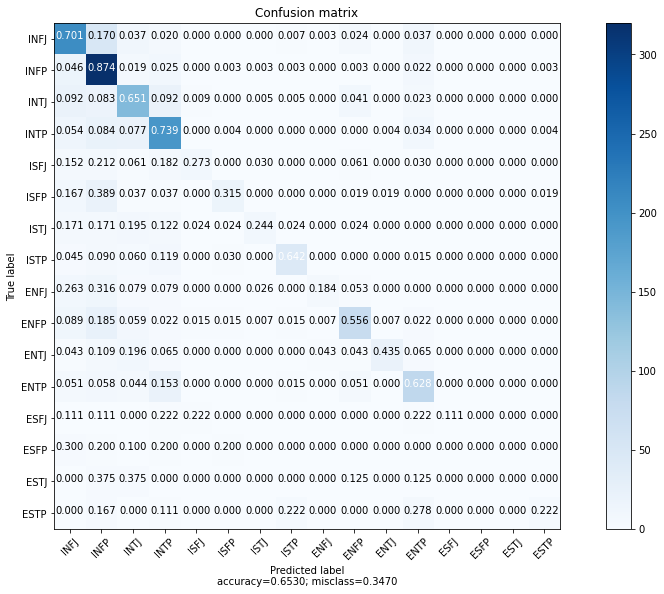

In [ ]:
plot_confusion_matrix(cm_logistic, list(class16_mbti_map.values()))